<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/UQ_varaition_0_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#first run

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_probability as tfp

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git


fatal: destination path 'neuraluq' already exists and is not an empty directory.


In [ ]:
tf.__version__

'2.13.0'

In [ ]:
tfp.__version__

'0.20.1'

In [ ]:
import neuraluq.neuraluq as neuq

In [ ]:
import neuraluq.neuraluq as neuq
import neuraluq.neuraluq.variables as neuq_vars
from neuraluq.neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

#**For pharmacokinetic problem**

In [ ]:
def load_data():
    t_d = np.array([0, 1, 2, 4, 7, 14]).reshape([-1, 1])
    Q1 = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880]).reshape([-1, 1])
    Q2 = np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612]).reshape([-1, 1])
    return t_d, Q1, Q2


def sird(t, u, ft):

    V1 = 254.5
    V2 = 1000
    f1 = 0.0

    # Q1, Q2, ft = tf.split(u, 3, axis=-1)
    Q1, Q2 = tf.split(u, 2, axis=-1)
    ft = ft


    # k = nn.softplus(ft)
    k  = ft
    Q1_t = tf.gradients(Q1, t)[0]
    Q2_t = tf.gradients(Q2, t)[0]

    f1 = Q1_t + k * (Q1/V1 - Q1/V2)- f1
    f2 = Q2_t - k * (Q1/V1 - Q2/V2)
    print(f1.shape, f2.shape)

    return tf.concat([f1, f2], axis=-1)


def scaling(inputs, a=1, b=0):
    """Applies linear transformation, i.e. a*inputs + b."""
    return a * inputs + b


# def Samplable(t_u_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn):
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft):
    # layers_beta = layers_gamma = layers_nu = layers_bgn
    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_u, mean=0, sigma=0.2),
    )
    process_ft = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_ft,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_ft, mean=0, sigma=0.2),
    )

    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=t_u_train, targets=u_train, processes=[process_u,process_ft], sigma=noise,
    )
    # inputs=t_u_train, targets=u_train, processes=[process_u], sigma=noise, out_dims=[[0, 1]]
    # print(f_train.shape, t_f_train.shape)

    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_ft],
        pde=lambda *args: sird(*args),
        sigma=0.02,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_ft],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=2000,
        init_time_step=0.01,
        leapfrog_step=100,
        seed=666,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: ", np.mean(results))

    processes = [process_u, process_ft]
    return processes, samples, model


@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft):

    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_u),
    )
    process_ft = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_ft,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_ft),
    )

    # build losses
    loss_u = neuq.likelihoods.MSE(
        inputs=t_u_train, targets=u_train, processes=[process_u], multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_ft],
        pde=lambda *args: sird(*args),
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_ft],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=10, num_iterations=30000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_ft]
    return processes, samples, model



@neuq.utils.timer
def Variational(t_u_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft):

    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers_u, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers_u, mean=0, sigma=0.5),
        posterior=neuq_vars.fnn.Variational(
            layers=layers_u, mean=0, sigma=0.01, trainable=True
        ),
    )

    process_ft = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers_ft, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers_ft, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.Variational( layers=layers_ft, mean=0, sigma=0.5, trainable=True),
    )


    likelihood_u = neuq.likelihoods.Normal(
        inputs=t_u_train, targets=u_train, processes=[process_u], sigma=noise,
    )
    # inputs=t_u_train, targets=u_train, processes=[process_u], sigma=noise, out_dims=[[0, 1]]
    # print(f_train.shape, t_f_train.shape)

    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_ft],
        pde=lambda *args: sird(*args),
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_ft],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=100,
        num_samples=10000,
        num_iterations=50000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_ft]
    return processes, samples, model


@neuq.utils.timer
def MCD(t_u_train, u_train, t_f_train, f_train, noise, layers):

    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model

In [ ]:
t, Q1, Q2 = load_data()
t_train, Q1_train, Q2_train = t, Q1, Q2
t_f_train, f_train = t_train.copy(), np.zeros([Q1.shape[0], 2])
t_test, Q1_test, Q2_test = t, Q1, Q2

In [ ]:
scale = 1
# N = (n / scale).astype(np.float32)
Q1_train, Q2_train = Q1_train / scale, Q2_train / scale
# t_train, I_train, R_train, D_train = t_train[::4], I_train[::4], R_train[::4], D_train[::4]
u_train = np.concatenate([Q1_train, Q2_train], axis=-1)

layers_u = [1, 50, 50, 50, 2]  # layers for SIRD
layers_ft = [1, 20,20, 1]  # layers for ft
noise = 0.02

In [ ]:
# processes, samples, model = Samplable(
#     t_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft,
# )
# processes, samples, model = Trainable(
#     t_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft,
# )

processes, samples, model = Variational(
    t_train, u_train, t_f_train, f_train, noise, layers_u, layers_ft,
)

Supporting backend tensorflow.compat.v1

Compiling a VI method

(100, 6, 1) (100, 6, 1)
Iteration:  0 , loss:  22644.719
Iteration:  100 , loss:  18363.447
Iteration:  200 , loss:  17792.04
Iteration:  300 , loss:  17238.07
Iteration:  400 , loss:  16683.69
Iteration:  500 , loss:  16143.586
Iteration:  600 , loss:  15607.787
Iteration:  700 , loss:  15072.456
Iteration:  800 , loss:  14543.241
Iteration:  900 , loss:  14008.62
Iteration:  1000 , loss:  13305.118
Iteration:  1100 , loss:  12510.106
Iteration:  1200 , loss:  11983.96
Iteration:  1300 , loss:  11473.661
Iteration:  1400 , loss:  10946.205
Iteration:  1500 , loss:  10427.346
Iteration:  1600 , loss:  9931.599
Iteration:  1700 , loss:  9420.314
Iteration:  1800 , loss:  8934.528
Iteration:  1900 , loss:  8457.247
Iteration:  2000 , loss:  7972.826
Iteration:  2100 , loss:  7520.1226
Iteration:  2200 , loss:  7036.0894
Iteration:  2300 , loss:  6578.487
Iteration:  2400 , loss:  6125.996
Iteration:  2500 , loss:  5679.493
I

In [ ]:
u_pred, f_pred = model.predict(
    t_test, samples, processes, pde_fn=None)

Q1_pred, Q2,pred= np.split(u_pred, 2, axis=-1)

KeyboardInterrupt: ignored

In [ ]:
mu_Q1 = np.mean(Q1_pred, axis=0) * scale
std_Q1 = np.std(Q1_pred, axis=0) * scale
mu_Q2 = np.mean(Q2_pred, axis=0) * scale
std_Q2 = np.std(Q2_pred, axis=0) * scale
mu_f = np.mean(f_pred, axis=0) * scale
std_f = np.std(f_pred, axis=0) * scale
# plt.plot(t_test, Q1, label="reference of Q1")
plt.plot(t_test, mu_Q1, label="mean of Q1")
# plt.plot(t_test, Q1_pred, label="mean of Q1")
plt.plot(t_train, Q1_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_Q1 + 2 * std_Q1).reshape([-1]),
    (mu_Q1 - 2 * std_Q1).reshape([-1]),
    alpha=0.3,
)
# plt.plot(t_test, Q2, label="reference of Q2")
plt.plot(t_test, mu_Q2, label="mean of Q2")
plt.plot(t_train, Q2_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_Q2 + 2 * std_Q2).reshape([-1]),
    (mu_Q2 - 2 * std_Q2).reshape([-1]),
    alpha=0.3,
)
# plt.plot(t_test, f_pred, label="reference of R")
# plt.plot(t_test, mu_f, label="mean of D (re-scaled)")
# # plt.plot(t_train, f_train * scale, ".", label="observations")
# plt.fill_between(
#     t_test.reshape([-1]),
#     (mu_f + 2 * std_f).reshape([-1]),
#     (mu_f - 2 * std_f).reshape([-1]),
#     alpha=0.3,
# )
# plt.plot(t_test, f, label="reference of D")
plt.legend()
plt.show()

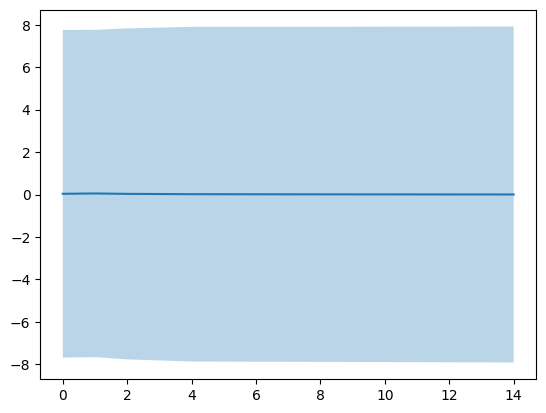

In [ ]:
mu_f = np.mean(f_pred, axis=0) * scale
std_f = np.std(f_pred, axis=0) * scale
# plt.plot(t_test, f_pred, label="reference of f")
plt.plot(t_test, mu_f, label="mean of f")
# plt.plot(t_train, f_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_f + 2 * std_f).reshape([-1]),
    (mu_f - 2 * std_f).reshape([-1]),
    alpha=0.3,
)

In [ ]:
t, Q1, Q2 = load_data()
t_train, Q1_train, Q2_train = t, Q1, Q2
t_f_train, f_train = t_train.copy(), np.zeros([Q1.shape[0], 2])
t_test, Q1_test, Q2_test = t, Q1, Q2

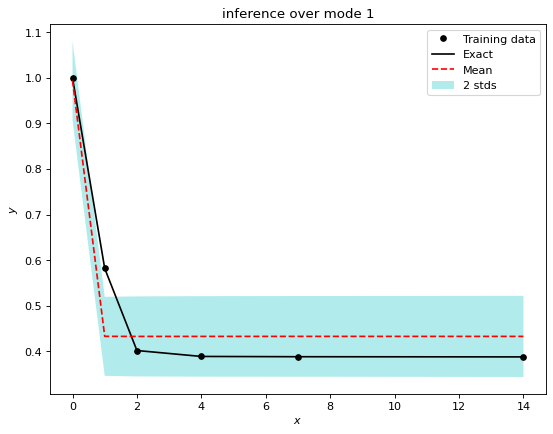

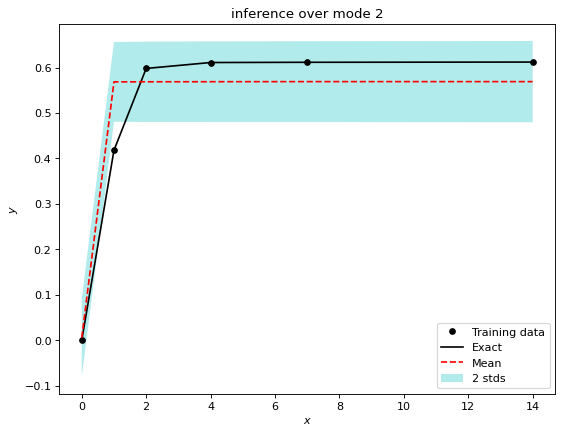

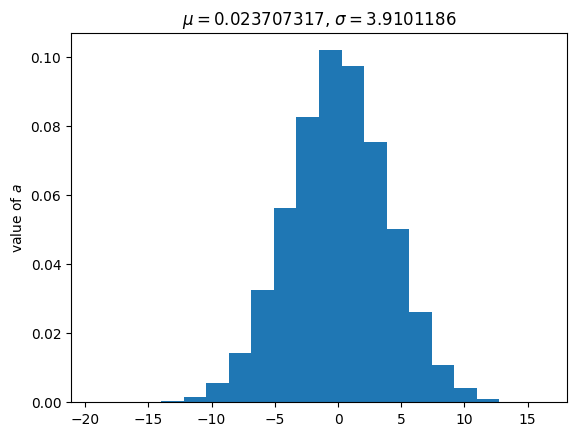

In [ ]:
def plots(u_pred):
    Q1_pred, Q2_pred= np.split(u_pred, 2, axis=-1)
    t, Q1, Q2 = load_data()
    t_train, Q1_train, Q2_train = t, Q1, Q2
    t_f_train, f_train = t_train.copy(), np.zeros([Q1.shape[0], 2])
    t_test, Q1_test, Q2_test = t, Q1, Q2

    neuq.utils.plot1d(
        t_train,
        Q1_train,
        t_test,
        Q1_test,
        Q1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_train,
        Q2_train,
        t_test,
        Q2_test,
        Q2_pred[..., 0],
        title="inference over mode 2",
    )


############################### Postprocessing ###################################
plots(u_pred)
neuq.utils.hist(f_pred.flatten(), name="value of $a$")


#**example**

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.317 

Execution time for 'Samplable' function is: 162.077 s, 2.701 mins


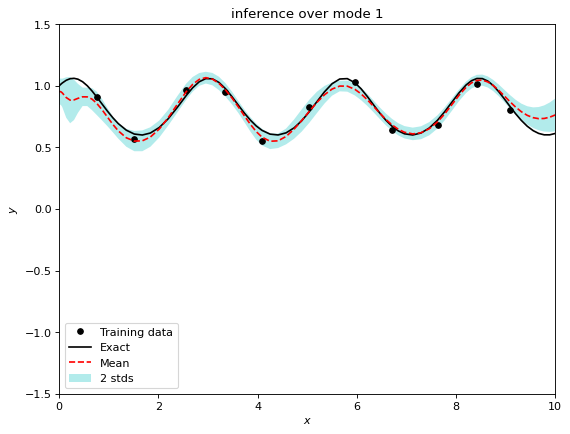

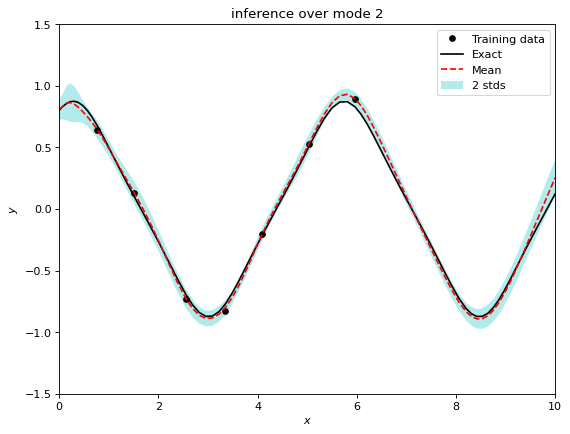

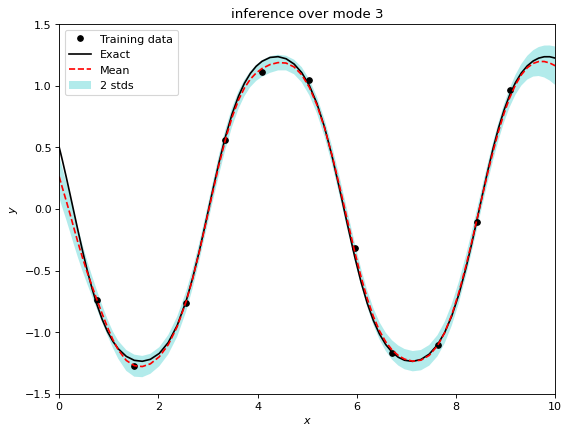

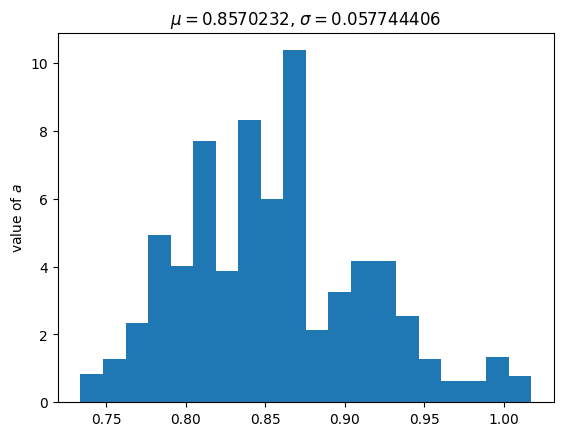

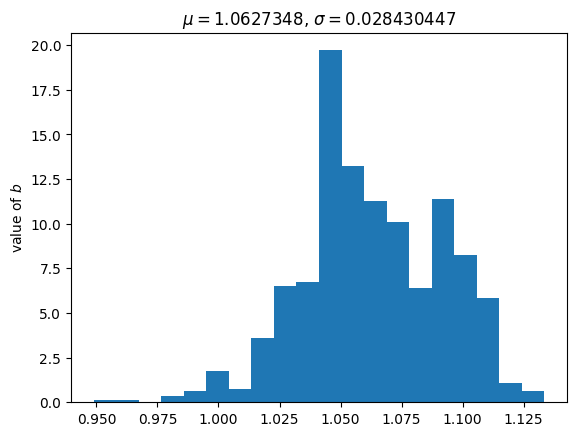

In [ ]:

def load_data():
    data = sio.loadmat("/content/neuraluq/dataset/KO_train.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test


def ode_fn(t, u, a, b):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]

    f1 = u1_t - a * u2 * u3
    f2 = u2_t - b * u1 * u3
    f3 = u3_t + (a + b) * u1 * u2
    return tf.concat([f1, f2, f3], axis=-1)


@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=666,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n" % (np.mean(results)))

    processes = [process_u, process_a, process_b]
    return processes, samples, model


@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]
    # build processes
    ############# Sequential training #############
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    ############# Parallelized training #############
    # num = 70
    # process_u = neuq.process.Process(
    #     surrogate=neuq.surrogates.FNN(layers=layers),
    #     posterior=neuq_vars.pfnn.Trainable(
    #         layers=layers, num=num, regularizer=tf.keras.regularizers.l2(1e-7)
    #     ),
    # )
    # process_a = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.pconst.Trainable(value=0, num=num),
    # )
    # process_b = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.pconst.Trainable(value=0, num=num),
    # )
    # method = neuq.inferences.DEns(
    #     num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3), is_parallelized=True,
    # )

    # build losses
    loss_u13 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        multiplier=1.0,
    )
    loss_u2 = neuq.likelihoods.MSE(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[loss_u13, loss_u2, loss_f],
    )
    # assign and compile method
    # method = neuq.inferences.SEns(num_samples=20, num_iterations=20000)
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model


@neuq.utils.timer
def Variational(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.Variational(
            layers=layers, mean=0, sigma=0.01, trainable=True
        ),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model


@neuq.utils.timer
def MCD(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model


def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]  # training data

    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )


if __name__ == "__main__":
    ################## Load data and specify some hyperparameters ####################
    data = load_data()
    t_u_train, u_train, t_f_train, f_train, noise = data[:5]
    t_test, u_test = data[5:]
    layers = [1, 50, 50, 3]

    ####################### Build model and perform inference ########################
    # All models share the same general procedure:
    # Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
    # Step 2: build prior and/or posterior using [variables]
    # Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
    # Step 4: build likelihood, given noisy measurements, using [likelihoods]
    # Step 5: build model using [models]
    # Step 6: create an inference method and assign it to the model using [inferences]
    # Step 7: perform posterior sampling using [model.run]

    ############################### Choose framework #################################
    processes, samples, model = Samplable(
        t_u_train, u_train, t_f_train, f_train, noise, layers
    )
    # processes, samples, model = Trainable(
    #     t_u_train, u_train, t_f_train, f_train, noise, layers
    # )

    # Note: Variational tends to work better, visually, if noise for the likelihood is set
    # to be small, based on our experience. However, if the noise is known, we can't justify setting it to a small value,
    # just to produce better-looking results.
    # processes, samples, model = Variational(
    #     t_u_train, u_train, t_f_train, f_train, noise, layers
    # )
    # processes, samples, model = MCD(
    #     t_u_train, u_train, t_f_train, f_train, noise, layers
    # )

    ################################# Predictions ####################################
    u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

    ############################### Postprocessing ###################################
    plots(u_pred, t_test, u_test, t_u_train, u_train)
    neuq.utils.hist(a_pred.flatten(), name="value of $a$")
    neuq.utils.hist(b_pred.flatten(), name="value of $b$")